# Report Notebook

#### Identifying Olympic Athletes that used Performance Enhancing Drugs during the past Summer Olympic Games. 
## Contents
- Notebook Summary
- Library and data importing
- Exploratory Data Analysis
- Data Preprocessing
- Baseline Model and Evaluation
- Model Iterations
- Conclusions drawn from final model

## Notebook Summary

This notebook provides a high level summary of the process undergone to achieve the task of identifying PED use amongst Olympic Athletes. The dataset used for this project was gathered from many different sources in an attempt to find which variables play a role in determining positive or negative PED use. During the initial analysis, I chose to select the results of track and field events for a predicitive classification model. This being due to the fact that a majority of the track and field events contain heats (rounds) which provide event results for each individual athlete and per each individual race. 

The base dataset used was retrieved from Kaggle and contained athletes from the Summer Olympic Games for the past 120 years. This [athlete dataset](https://github.com/jwong853/Olympic_PED_use/tree/master/data/athletes_dataset) also provides information on athletes such as gender, country, weight, and height. From there, each track and field  event results were scraped from [Olympic.org](https://www.olympic.org/olympic-results) and merged with the athlete dataframe by matching names. A dataset containing athletes with positive PED cases was scraped from [Wikipedia](https://en.wikipedia.org/wiki/List_of_doping_cases_in_athletics). 

Then performed Exploratory Data Analysis to get a better understanding of the data I was working with. This included created visualizations such as correlation plots and bar graphs showing positive PED tests in each Olympic Game.

After getting a complete dataframe I moved on to the data preprocessing, filling missing values as well as scaling numerical and encoding categorical features. 

## Libraries and Data Importing

#### _The libraries used for this project can be found in the environment.yml file [here](https://github.com/jwong853/Olympic_PED_use/blob/master/environment.yml)._

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

#### EDA and data preprocessing libraries

In [2]:
import requests
from requests import get
import pandas as pd
import numpy as np
import pdfplumber
import tabula
from Olympic_PED_use.src import functions as fn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from bs4 import BeautifulSoup
import certifi
import urllib3
import re
from csv import DictReader, DictWriter

#### Modeling and evaluation libraries

In [3]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### Loading in the .zip file containin athletes and general information, The cell for unzipping the athletes file is below for reference but the dataset will be loaded with a function from the [src](https://github.com/jwong853/Olympic_PED_use/tree/master/src) folder.

In [4]:
from zipfile import ZipFile
zf = ZipFile('../../data/athletes_dataset/compressed_athlete_events.zip', 'r')
zf.extractall('../../data/athletes_dataset/')
zf.close()

## Data Preprocessing

 - As discussed earlier the creation of this model was to aid the IOC in identifying PED use. Performing initial Exploratory Data Analysis allowed me to scrape together a dataset with only athletes that competed in the Summer Games from 2004-2016. To do this, I created individual tables for each event per year. These tables were then combined together and ordered by year of Olympic Games. 

 - Next, I repeated the above process for the results of each event. This wasn't as simple as some results show all heats, the semi-final, quarter-final, and final. While others only show the final result, not including atheletes from all of the individual heats. Do to this inconsistency I only gathered data that provided at least 2 race results per athlete. Since there are athletes that compete in more than one event as well as more than one Olympic Game, I chose to add these results to the dataset as individual columns. Since a majority of the datasets containing this information were from Olympedia, creating a dataframe and merging the results with the atheltes did not pose many issues.  

 - From there, I scraped multiple datasets containing athletes that had been flagged for PED use during the Olympics and only kept the data relevant for 2004-2016 Summer Sports. After cross-referencing the datasets, I ended up with a dataset containing 579 records for doping. To indicate whether or not an athlete had been found guilty of doping in the athelte dataset, I created a binary feature showing 1 for positive PED use and 0 for negative PED use. When trying to join this feature to the athlete dataframe, I was only successful in matching around 85 athletes from the doping datasets. Not all of the 579 athletes in the doping records were from the Summer Games, I found multiple athlete results from non-Olympic sporting events held during the same time period. After removing as many as I could find and formatting the names in the doping dataset, I was able to match on around 240 athletes. 
 
 - After combining these datasets, I needed to prepare the data for modeling. I began by filling the missing values for event results with 0 since the athlete had not participated in that event. Then, I subsetted the numerical features and categorical features seperately, Standard Scaling the numerical features and One Hot Encoding the categorical features. For the events such as the marathon where the event times were in hours, I converted to minutes. I also converted the event results provided in minutes, to seconds.


I have provided an example of the preprocessing steps taken when loading in each result table
- Filling in the flagged column's missing values with 0 (no positive PED use)
- Inserting a column 'ped_use' to merge the summed results on
- Defining result columns that were merged to the dataframe so I can get the sum
- Subsetting the dataframe to only the event result columns and inserting a 'ped_use' column 
- Filling the missing values in the height and weight features by adding the before and after values and dividing by 2

In [5]:
df = pd.read_csv('../../data/model_df.csv')

In [6]:
# Defining dataframe columns consisting of event results
result_cols = df.columns[15:56]
# Filling in the missing values with 0 since the athlete did not participate
# in that particular event.
for x in df[result_cols]:
    df[x] = df[x].fillna(value=0.0)
# Filling the na values in the flagged column with 0
df.flagged = df.flagged.fillna(value=0)
# Removing id since it does not provide any predictive benefit to our model
df = df.drop(['id'], axis=1)
# Creating the 'ped_use' feature to hold binary values indicating whether or not an athlete has a PED case
df.insert(56, 'ped_use', 0)
# Subsetting dataframe to only columns with results in order to sum them and input the value as a new feature
results = df[result_cols]
results.insert(41, 'ped_use', 0)
results.ped_use = results[list(results.columns)].sum(axis=1)
df.ped_use = results.ped_use
df.rename(columns={'ped_use':'results'}, inplace=True)
# Removing Substance and event_y as they do not contain relevant information for modeling. This project is geared towards
# finding wheather or not PED use was present and not the type of PED. The event_y column just provides the event that an
# athlete is competing in. I won't need this as the result tables have been matched with the column names being the event.
df = df.drop(['substance', 'event_y'], axis=1)
# Filling the NA values in the height and weight features by adding the height from the forward position, back position,
# dividing the value by 2.
df.height = (df.height.fillna(method='ffill') + df.height.fillna(method='bfill')/2)
df.weight = (df.weight.fillna(method='ffill') + df.weight.fillna(method='bfill')/2)
df.result_discus_womens_london = df.result_discus_womens_london.fillna('00.00')
# Converting the medal feature to numeric values
medal_numeric = {np.nan: 0,
                 'Bronze': 1,
                 'Silver': 2,
                 'Gold': 3}
df['medal'] = df.medal.replace(medal_numeric)

/opt/anaconda3/envs/olympic-env/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


#### Below is a correlation heatmap of the dataframe being used for the project. It seems that the variables do not show a high correlation but weight looks to have an impact on the discus throw for men and women.

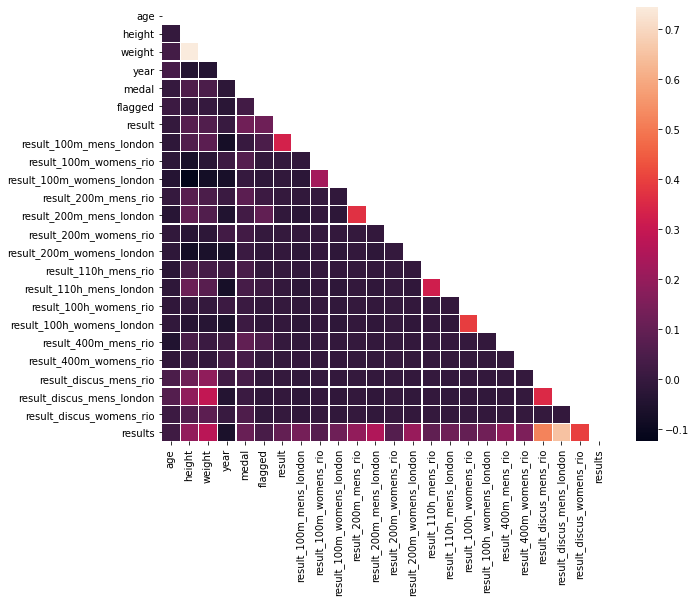

In [7]:
fn.plot_corr(df)

## Exploratory Data Analysis

#### The bar graph below shows the number of doping positives per Olympic Game. The amount of Doping cases has been on an upwards trend until the London Games in 2012. This could be due to the fact that the World Anti-Doping Agency was not created until the late 90's. The goal of WADA is to promote and coordinate the fight against doping in sports. The World Anti-Doping Code was not created until 2003, which provides an international standard for testing and investigation within elite sports organizations. It is hard to say whether there's been a significant increase in doping or if this is due to the limitations of testing.

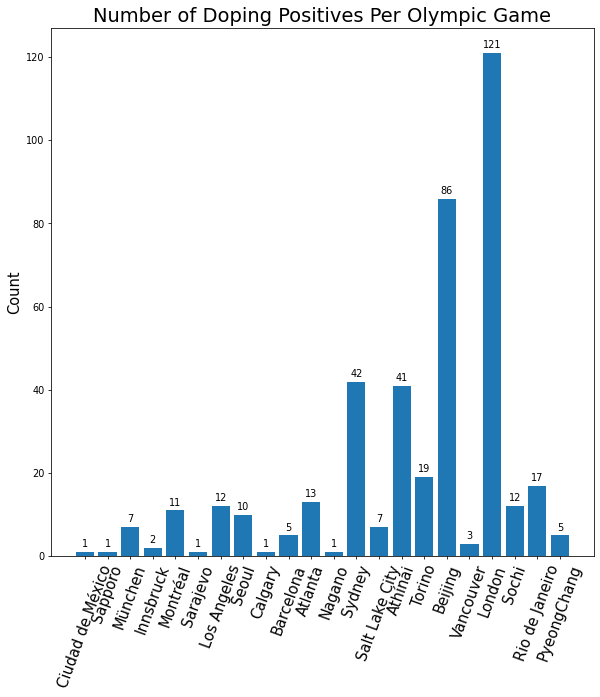

In [12]:
url = 'https://olympstats.com/2019/01/18/all-olympic-doping-positives-the-count-by-games/'
req = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',
                         ca_certs=certifi.where())
res = req.request('GET', url)
soup = BeautifulSoup(res.data, 'html.parser')
contents = soup.find_all(class_= 'table-responsive')    
ped_by_country_df = pd.read_html(str(contents))[0]
ped_by_country_df
ped_by_country_df = ped_by_country_df.drop(22)
ped_by_country_df.sort_values('Year', inplace=True)

x = ped_by_country_df.City
width = 0.3
labels = ped_by_country_df['City']

fig, ax = plt.subplots(figsize=(10,10), dpi=70)
rect = ax.bar(ped_by_country_df['City'], ped_by_country_df['###'])
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Number of Doping Positives Per Olympic Game', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=15, rotation=70)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rect)


plt.show();

# 

# 

#### Defining Continuous and Categorical features to be scaled and encoded. The dataframe will be loaded with a function that formats the columns, drops duplicate values and performs a train test split.

In [13]:
cont_features = ['age', 'height', 'weight', 'results']
cat_features = ['sex', 'team', 'noc', 'season', 'city', 'sport',
                       'event_x', 'medal']

In [14]:
X_train, X_test, y_train, y_test = fn.preprocess_df(df, cont_features, cat_features)

## Baseline Model

#### Instantiating Dummy Classifier as a baseline model. Evaluating the performance by the mean cross_val_score over 5 splits 
#### I have chosen to optimize for recall score, limiting the amount of false negatives. The model classifying a clean athlete in the positive PED class wouldn't be as bad as the model classifying a doping athlete in the negative PED class. When the model flags a clean athlete, their sample can be retested and the results would prove they are clean. If the model classifys a doping athlete as a clean athlete, their sample may not get selected for re-testing. 

0.05
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1031
         1.0       0.00      0.00      0.00        17

    accuracy                           0.97      1048
   macro avg       0.49      0.49      0.49      1048
weighted avg       0.97      0.97      0.97      1048

Recall:  0.0
Accuracy:  0.9675572519083969
Precision:  0.0


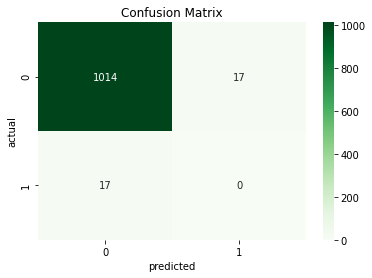

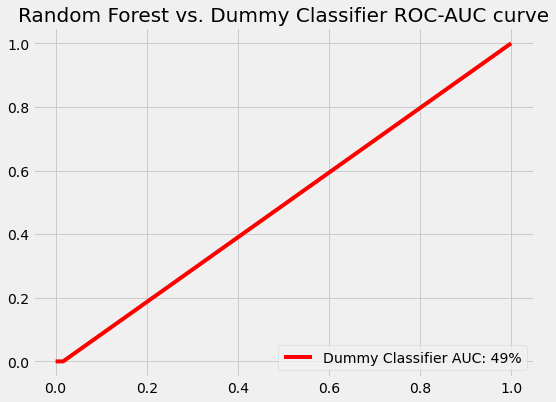

In [15]:
fsm = DummyClassifier(random_state=42)
fsm.fit(X_train, y_train)
print(np.mean(cross_val_score(fsm, X_test, y_test, scoring='recall',
                             cv=5, n_jobs=-1)))
fn.evaluation(y_test, fsm.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, fsm.predict(X_test))
roc_auc = auc(fpr, tpr)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))    
plt.plot(fpr, tpr, c='r', label='Dummy Classifier AUC: 49%')
plt.title('Random Forest vs. Dummy Classifier ROC-AUC curve', fontsize=20)
plt.legend(loc='lower right')
plt.savefig('auc.png', bbox_inches='tight', transparent=True)

- This model was cross validated with the test split over 3 folds. I was not able to cross validate with the training data since I had very few positive doping cases. The results of this model were very poor, out of the 17 positive PED cases, the model did not successfully classify any of them as positive. I believe this is due to the class imbalance issue, in total the dataframe contains 84 positive PED cases and close to 5000 non-PED cases. 
- The mean cross val score over 5 splits was only 5% here with the recall even worse at 0
- By looking at the feature importances of the model, we can see that age, height, and weight play a large role in predicting PED use. Moving forward I would like to feed the model more features from events such as speed increase within the first 20% and the last 20% of a race.

## Model Iterations

#### Instantiating a Random Forest Classifier with
- max_depth: 60
- min_samples_split: 2
- n_estimators: 1000

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


0.0


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1031
         1.0       1.00      0.47      0.64        17

    accuracy                           0.99      1048
   macro avg       1.00      0.74      0.82      1048
weighted avg       0.99      0.99      0.99      1048

Recall:  0.47058823529411764
Accuracy:  0.9914122137404581
Precision:  1.0


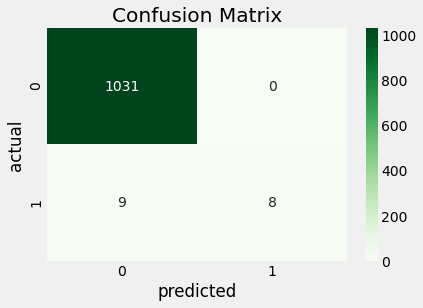

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


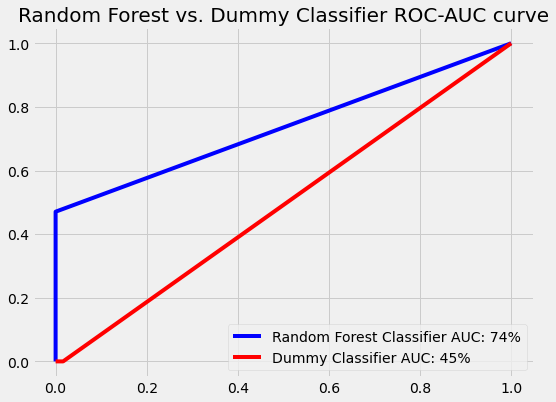

In [17]:
rf2 = RandomForestClassifier(max_depth=60, min_samples_split=2, 
                             n_estimators=1000, n_jobs=-1, 
                             verbose=1, random_state=42)
rf2.fit(X_train, y_train)

print(np.mean(cross_val_score(rf2, X_test, y_test, scoring='recall',
                       n_jobs= -1, verbose=1, cv=5)))

fn.evaluation(y_test, rf2.predict(X_test))
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, rf2.predict(X_test))
rf_roc_auc = auc(rf_fpr, rf_tpr)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))    
plt.plot(rf_fpr, rf_tpr, c='b', label='Random Forest Classifier AUC: 74%')
plt.plot(fpr, tpr, c='r', label='Dummy Classifier AUC: 45%')
plt.title('Random Forest vs. Dummy Classifier ROC-AUC curve', fontsize=20)
plt.legend(loc='lower right')
plt.savefig('auc.png', bbox_inches='tight', transparent=True)

<AxesSubplot:>

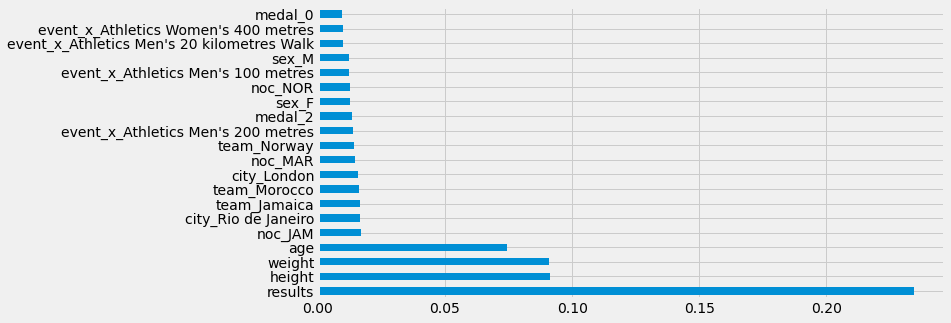

In [18]:
plt.style.use('fivethirtyeight')
feat_importances = pd.Series(rf2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=(10,5))

#### The Random Forest Classifier performed better than the dummy classifier, increasing the AUC from 49% to 74% The higher the AUC the better the model is at distinguishing the positive from the negative PED classes. I am aiming to reach the top left corner of the plot. (largest area under the curve)

#### Instantiating a Decision Tree Classifier with
- max_depth: 7
- min_samples_split: .13
These parameters were obtained by running the model in a for loop of different max_depths from 1-50. The greatest AUC was between the max_depths 5-10. Next I ran the model through a loop of different min_samples_split from 0.1-1.0. The greatest AUC here was between .1 and .15,

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1031
         1.0       1.00      0.82      0.90        17

    accuracy                           1.00      1048
   macro avg       1.00      0.91      0.95      1048
weighted avg       1.00      1.00      1.00      1048

Recall:  0.8235294117647058
Accuracy:  0.9971374045801527
Precision:  1.0


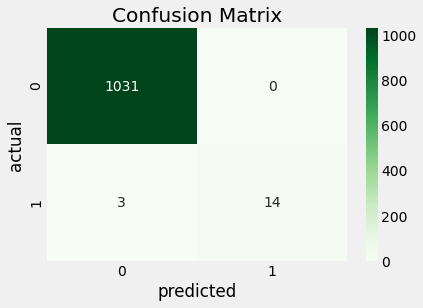

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


0.8222222222222223


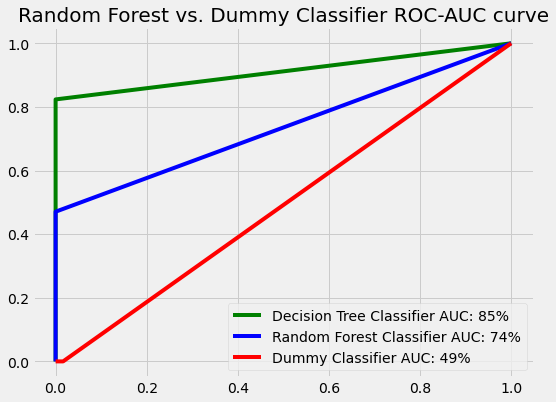

In [19]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=7,
                            min_samples_split=.13, random_state=42)
dt.fit(X_train, y_train)
preds = dt.predict(X_test)
fn.evaluation(y_test, preds)

print(np.mean(cross_val_score(dt, X_test, y_test, scoring='recall', 
                       cv=3, n_jobs= -1, verbose=1)))
d_fpr, d_tpr, thresholds = roc_curve(y_test, preds)
d_roc_auc = auc(d_fpr, d_tpr)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))  
plt.plot(d_fpr, d_tpr, c='g', label='Decision Tree Classifier AUC: 85%')
plt.plot(rf_fpr, rf_tpr, c='b', label='Random Forest Classifier AUC: 74%')
plt.plot(fpr, tpr, c='r', label='Dummy Classifier AUC: 49%')
plt.title('Random Forest vs. Dummy Classifier ROC-AUC curve', fontsize=20)
plt.legend(loc='lower right')
plt.savefig('auc.png', bbox_inches='tight', transparent=True)

- This model was cross validated with the test split over 3 folds. There was an increase in performance with the recall increasing to 82%. Out of the 17 positive PED cases, the model correctly flagged 12 of them.

- This model has the ability to classify positive PED use in athletes but I would like to improve on the class imbalance before deploying it to the International Olympic Committee.


## Conclusion

The Decision Tree Classifier was the best model at identifying PED use amongst Olympic Athletes. However, I do not believe the model has enough positive cases to train on. Moving forward I would like to include more athlete results and improve the number of matches in name spelling and punctuation for the seperate dataframes.